# Finetuning ImageNet Pretrained Model on BloodMNIST

In this notebook, we finetuned the ImageNet pretrained ResNet18 on BloodMNIST dataset. The pre-trained model should be trained on ImageNet with supervision. We compared two types of finetuning pipeline:

1. Finetune the last linear layer with backbone freezed (which is also linear-probing)
2. Finetune the backbone + last linear layer

We also implemented the Classification Activation Map to provide a visualization comparison between different finetuning pipelines.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.models import resnet18

from data import get_bloodmnist_loader
from utils import *

!nvidia-smi

/h/lkcai/anaconda3/envs/video_comp_py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Thu Nov 28 03:47:56 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:86:00.0 Off |                    0 |
| N/A   35C    P8    15W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
train_loader = get_bloodmnist_loader(split='train', batch_size=64)
val_loader = get_bloodmnist_loader(split='val', batch_size=100)

Using downloaded and verified file: /h/lkcai/.medmnist/bloodmnist_128.npz
Using downloaded and verified file: /h/lkcai/.medmnist/bloodmnist_128.npz


# Only finetune the last linear layer

In [6]:
num_classes = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18(pretrained=True)
for name, param in model.named_parameters():
    if name not in ["fc.weight", "fc.bias"]:
        param.requires_grad = False

criterion = nn.CrossEntropyLoss()

model.fc = nn.Linear(model.fc.in_features, num_classes)
model.fc.weight.data.normal_(mean=0.0, std=0.01)
model.fc.bias.data.zero_()

parameters = list(filter(lambda p: p.requires_grad, model.parameters()))
optimizer = optim.Adam(parameters, 0.01)

model = model.to(device)

In [7]:
# pre-trained classifier with random head
val_acc = validate(model, val_loader, device)
print(f"Pretrained Classifier with Random head - Val Acc: {val_acc:.2f}% ")

Pretrained Classifier with Random head - Val Acc: 18.40% 


100%|██████████| 187/187 [00:43<00:00,  4.29it/s]


[Epoch 1/10]: Train Loss: 0.9083 Train Acc: 70.56% | Val Acc: 73.77%


100%|██████████| 187/187 [00:43<00:00,  4.34it/s]


[Epoch 2/10]: Train Loss: 0.6153 Train Acc: 79.26% | Val Acc: 79.44%


100%|██████████| 187/187 [00:42<00:00,  4.37it/s]


[Epoch 3/10]: Train Loss: 0.5769 Train Acc: 80.41% | Val Acc: 84.05%


100%|██████████| 187/187 [00:43<00:00,  4.26it/s]


[Epoch 4/10]: Train Loss: 0.6007 Train Acc: 80.23% | Val Acc: 74.01%


100%|██████████| 187/187 [00:43<00:00,  4.29it/s]


[Epoch 5/10]: Train Loss: 0.6171 Train Acc: 80.56% | Val Acc: 81.60%


100%|██████████| 187/187 [00:42<00:00,  4.35it/s]


[Epoch 6/10]: Train Loss: 0.5981 Train Acc: 81.18% | Val Acc: 82.94%


100%|██████████| 187/187 [00:43<00:00,  4.29it/s]


[Epoch 7/10]: Train Loss: 0.6588 Train Acc: 79.97% | Val Acc: 81.43%


100%|██████████| 187/187 [00:42<00:00,  4.36it/s]


[Epoch 8/10]: Train Loss: 0.5989 Train Acc: 82.02% | Val Acc: 74.53%


100%|██████████| 187/187 [00:41<00:00,  4.48it/s]


[Epoch 9/10]: Train Loss: 0.5777 Train Acc: 81.87% | Val Acc: 82.48%


100%|██████████| 187/187 [00:41<00:00,  4.56it/s]


[Epoch 10/10]: Train Loss: 0.6177 Train Acc: 81.34% | Val Acc: 86.92%


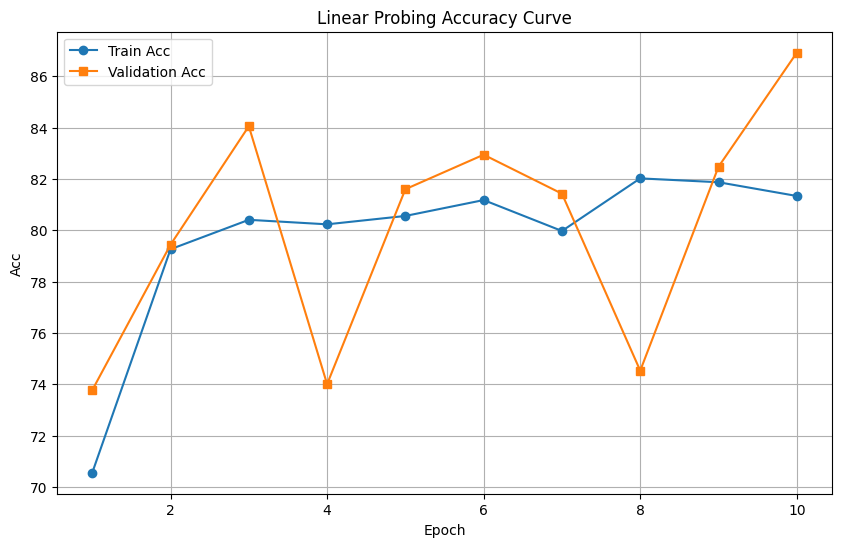

In [8]:
num_epochs = 10

train_acc_list = []
val_acc_list = []
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_acc = validate(model, val_loader, device)
    
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    
    print(f"[Epoch {epoch + 1}/{num_epochs}]: " + \
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, label='Train Acc', marker='o')
plt.plot(range(1, len(val_acc_list) + 1), val_acc_list, label='Validation Acc', marker='s')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Linear Probing Accuracy Curve')
plt.legend()
plt.grid(True)

plt.show()

In [20]:
save_path = "/h/lkcai/code/csc_pj_ckpts/bloodmnist_sup_ft_head.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_acc': val_acc,
}, save_path)

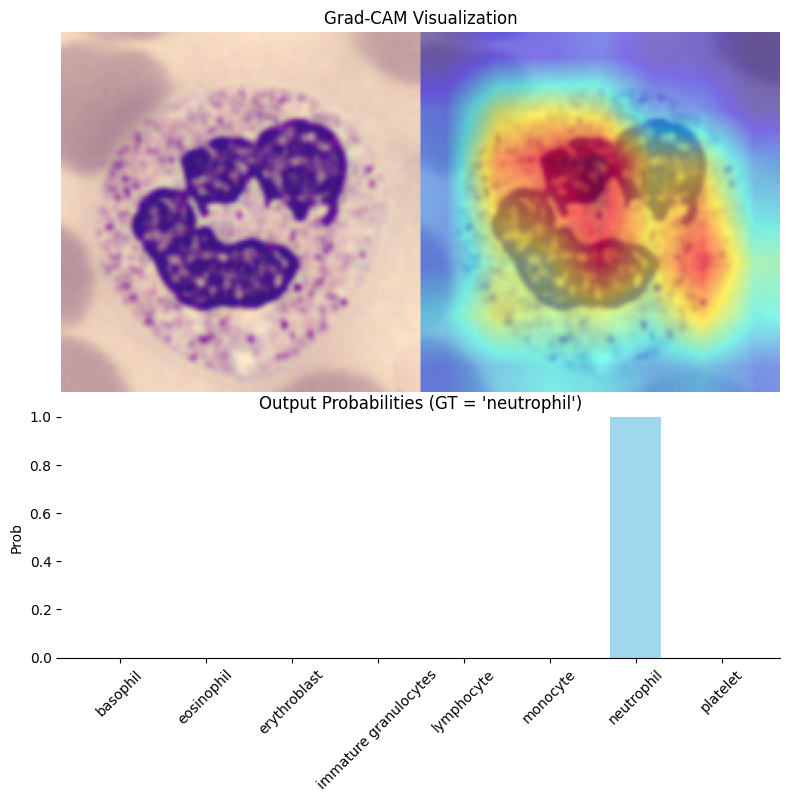

In [12]:
class_names = list(bloodmnist_label.values())

vis_res, output_probs, label = grad_cam_vis(model, val_loader, img_idx=88)

fig, axes = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 2]})

axes[0].imshow(vis_res)
axes[0].axis('off')
axes[0].set_title(f"Grad-CAM Visualization")

axes[1].bar(class_names, output_probs, color='skyblue', alpha=0.8, width=0.6)

axes[1].spines['left'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

axes[1].set_ylim([0, 1])
axes[1].set_ylabel("Prob")
axes[1].set_title(f"Output Probabilities (GT = '{class_names[label]}')")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('vis_results/cam_vis_head.png')
plt.show()

# Finetune the whole model: backbone + last linear layer

In [16]:
model = model.cpu()
for param in model.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()

model.fc = nn.Linear(model.fc.in_features, num_classes)
model.fc.weight.data.normal_(mean=0.0, std=0.01)
model.fc.bias.data.zero_()

optimizer = optim.Adam(model.parameters(), 0.01)

model = model.to(device)

In [17]:
# pre-trained classifier with random head
val_acc = validate(model, val_loader, device)
print(f"Pretrained Classifier with Random head - Val Acc: {val_acc:.2f}% ")

Pretrained Classifier with Random head - Val Acc: 6.72% 


100%|██████████| 187/187 [00:47<00:00,  3.94it/s]


[Epoch 1/10]: Train Loss: 1.6476 Train Acc: 41.51% | Val Acc: 63.20%


100%|██████████| 187/187 [00:46<00:00,  4.02it/s]


[Epoch 2/10]: Train Loss: 1.0930 Train Acc: 61.13% | Val Acc: 57.36%


100%|██████████| 187/187 [00:46<00:00,  3.99it/s]


[Epoch 3/10]: Train Loss: 0.9192 Train Acc: 67.57% | Val Acc: 59.17%


100%|██████████| 187/187 [00:46<00:00,  4.01it/s]


[Epoch 4/10]: Train Loss: 0.7813 Train Acc: 72.87% | Val Acc: 60.92%


100%|██████████| 187/187 [00:46<00:00,  4.02it/s]


[Epoch 5/10]: Train Loss: 0.7002 Train Acc: 75.16% | Val Acc: 71.85%


100%|██████████| 187/187 [00:47<00:00,  3.91it/s]


[Epoch 6/10]: Train Loss: 0.6193 Train Acc: 78.34% | Val Acc: 77.22%


100%|██████████| 187/187 [00:46<00:00,  4.00it/s]


[Epoch 7/10]: Train Loss: 0.5384 Train Acc: 81.11% | Val Acc: 69.68%


100%|██████████| 187/187 [00:46<00:00,  3.99it/s]


[Epoch 8/10]: Train Loss: 0.4864 Train Acc: 82.78% | Val Acc: 79.15%


100%|██████████| 187/187 [00:47<00:00,  3.98it/s]


[Epoch 9/10]: Train Loss: 0.4375 Train Acc: 84.66% | Val Acc: 80.96%


100%|██████████| 187/187 [00:47<00:00,  3.98it/s]


[Epoch 10/10]: Train Loss: 0.3903 Train Acc: 86.36% | Val Acc: 90.48%


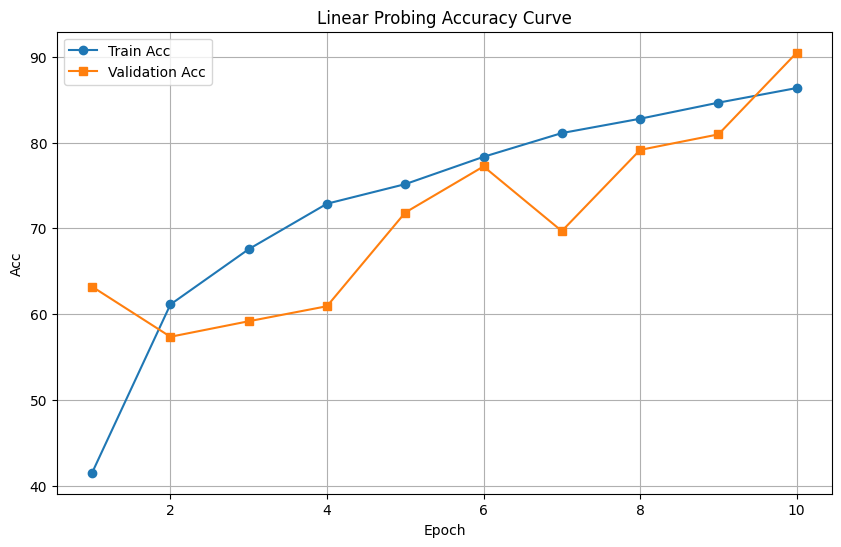

In [18]:
num_epochs = 10

train_acc_list = []
val_acc_list = []
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_acc = validate(model, val_loader, device)
    
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    
    print(f"[Epoch {epoch + 1}/{num_epochs}]: " + \
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, label='Train Acc', marker='o')
plt.plot(range(1, len(val_acc_list) + 1), val_acc_list, label='Validation Acc', marker='s')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Finetuning Accuracy Curve')
plt.legend()
plt.grid(True)

plt.show()

In [21]:
save_path = "/h/lkcai/code/csc_pj_ckpts/bloodmnist_sup_ft_all.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_acc': val_acc,
}, save_path)

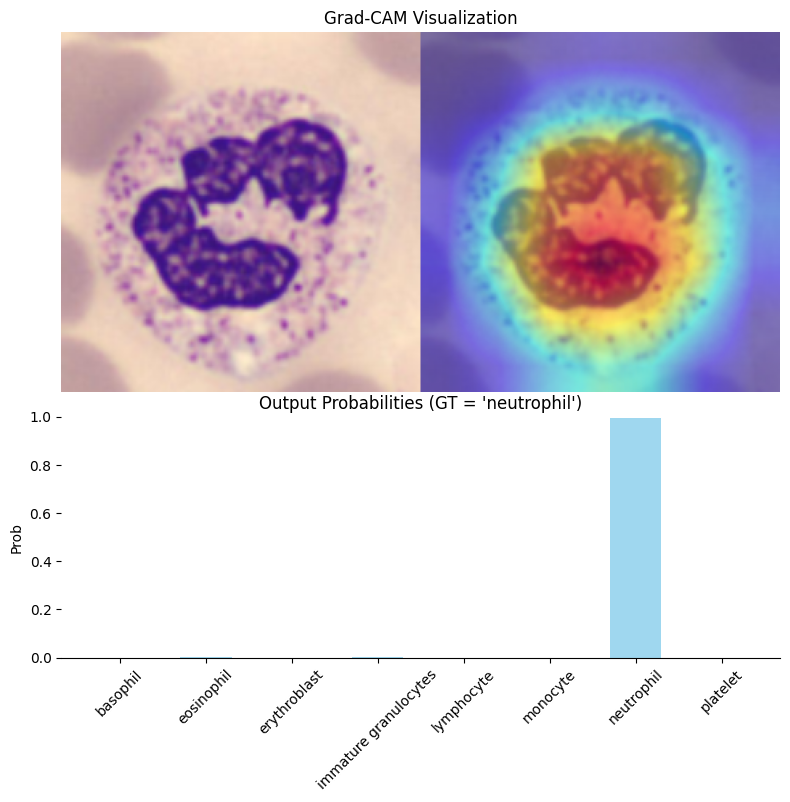

In [19]:
imgs, labels = next(iter(val_loader))

for param in model.parameters():
    param.requires_grad = True

idx = 88
target_layers = [model.layer4[-1]]
input_tensor = imgs[idx].unsqueeze(0)
rgb_img = imgs[idx].permute(1, 2, 0)
rgb_img = img_denormalize(rgb_img).numpy()
label = labels[idx].item()

targets = [ClassifierOutputTarget(label)]

with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    model_outputs = cam.outputs

vis_res = np.concatenate([rgb_img, visualization / 255], axis=1)

output_probs = model_outputs.squeeze().softmax(dim=0).detach().cpu().numpy()
class_names = list(bloodmnist_label.values())

fig, axes = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 2]})

# Plot the Grad-CAM visualization
axes[0].imshow(vis_res)
axes[0].axis('off')
axes[0].set_title(f"Grad-CAM Visualization")

# Plot the bar chart
axes[1].bar(class_names, output_probs, color='skyblue', alpha=0.8, width=0.6)

axes[1].spines['left'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

axes[1].set_ylim([0, 1])
axes[1].set_ylabel("Prob")
axes[1].set_title(f"Output Probabilities (GT = '{class_names[label]}')")
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout and show the figure
plt.tight_layout()
plt.savefig('vis_results/cam_vis_all.png')
plt.show()